# Feature Engineering

In [10]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import xgboost as xgb
from xgboost import plot_importance
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# load dataframe
# loans = pd.read_csv('./data/accepted_imputed.csv', low_memory=False)
# loans = loans.assign(issue_d=pd.to_datetime(loans['issue_d'], format='%Y-%m-%d'))

loans = pd.read_csv('./data/final.df.csv', low_memory=False)

loans = loans[(loans['loan_status'] == 'Fully Paid') | (loans['loan_status'] == 'Charged Off') | (loans['loan_status'] == 'Default')]
loans = loans.assign(paid_flag = np.where(loans['loan_status'].str.contains('Fully Paid'), 1, 0))

# loans = loans.drop(['policy_code'], axis=1)
loans = loans.drop(['loan_status', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'total_pymnt', 'recoveries', 'grade', 'debt_settlement_flag'], axis=1)

# Aaron's selection
loans = loans.drop(['total_rec_int', 'total_rec_late_fee', 'collections_12_mths_ex_med', 'tot_coll_amt'], axis=1)

In [4]:
# under sampling
# loans_paid = loans[loans['paid_flag'] == 1].sample(int(len(loans) * 0.2))
# loans_default = loans[loans['paid_flag'] == 0]
# loans = pd.concat([loans_paid, loans_default])

print(loans['paid_flag'].value_counts())

pd.set_option('display.max_columns', 200)
loans.head(5)

1    107725
0     92275
Name: paid_flag, dtype: int64


,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_sats,num_bc_tl,num_rev_tl_bal_gt_0,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bc_limit,fico_range_mean,sub_grade_num,emp_length_num,term,home_ownership,verification_status,purpose,addr_state,initial_list_status,application_type,disbursement_method,paid_flag
0,12000,9.17,382.55,85000.0,7.54,0,0,35,12,0,11299,65.3,21,0,25937,1,0,0,0,25,0,71,1,4,5014,66,17300.0,1,0,0,4,2358,2817,77.3,0,0,173,442,5,5,2,5,21,35,3,5,6,10,9,0,0,1,76.2,60.0,0,0,12400.0,662.0,7,10,36 months,MORTGAGE,Source Verified,home_improvement,TX,w,Individual,Cash,1
1,10000,8.90,317.54,40000.0,27.60,0,0,62,13,0,11117,86.2,16,0,44289,0,6,0,1,95,38184,62,0,0,3735,79,12900.0,1,2,2,1,3407,141,98.1,0,0,91,84,22,22,0,22,8,53,0,3,3,3,6,0,0,0,100.0,100.0,0,0,7400.0,712.0,5,3,36 months,RENT,Source Verified,credit_card,OH,w,Individual,Cash,1
2,8000,9.99,258.10,40000.0,31.89,0,0,38,11,0,15173,39.2,18,0,42607,0,2,1,0,35,25809,67,0,3,4255,44,38700.0,0,0,0,3,3873,12055,52.7,0,0,96,180,11,11,0,11,16,38,0,5,5,6,7,0,0,1,94.4,40.0,0,0,25500.0,702.0,8,8,36 months,RENT,Source Verified,debt_consolidation,CO,f,Individual,Cash,1
3,3600,16.99,128.34,96000.0,23.19,0,5,42,31,0,7645,51.3,49,0,366088,3,19,5,16,59,140226,105,1,5,1802,113,14900.0,6,0,6,22,11809,5856,52.8,0,0,147,50,1,1,7,1,1,47,0,6,7,7,9,0,0,6,95.7,0.0,0,0,12400.0,662.0,18,10,36 months,MORTGAGE,Verified,debt_consolidation,IL,f,Individual,Cash,1
4,34600,10.56,1125.57,53000.0,29.10,0,0,85,13,0,6570,11.0,28,0,38203,0,3,1,1,7,31633,76,0,0,4476,38,59600.0,2,0,3,1,2939,28730,18.6,0,0,204,104,31,7,0,32,1,78,0,3,6,9,3,0,0,1,100.0,0.0,0,0,35300.0,787.0,8,10,36 months,MORTGAGE,Verified,debt_consolidation,OH,w,Individual,Cash,1


In [4]:
# select only numeric variables
# target_col = []
# col_null_cnt = loans.isnull().sum().sort_values(ascending=False)
# for k, v in col_null_cnt.iteritems():
#     if v == 0:
#         if is_numeric_dtype(loans[k].dtype) and k != 'paid_flag':
#             target_col = target_col + [k]

# loans = loans[target_col]

In [5]:
# dummify
target = loans['paid_flag']
loans = loans.drop(['paid_flag'], axis=1)

loans = pd.get_dummies(loans, drop_first=True)
loans_norm = preprocessing.normalize(loans)

# seprate training & test set
X_train, X_test, Y_train, Y_test = train_test_split(loans_norm, target, shuffle=True, test_size=0.2)

# Modeling

### 1. Logistic Regression

In [6]:
logit = linear_model.LogisticRegression(solver='liblinear', max_iter=1000)

param = dict(C=[0.001, 0.01, 0.1, 1, 10, 100, 1000], penalty=['l1', 'l2'])

logit_grid = GridSearchCV(logit, param, cv=5, verbose=0)

best_mdl = logit_grid.fit(X_train, Y_train)

# best hyperparameter
print('best hyperparameter')
print(best_mdl.best_estimator_.get_params())
print()

# best cross-validation score
print('best cross-validation score: ' + str(best_mdl.score(X_train, Y_train)))
print()

Y_pred = logit_grid.predict(X_test)

rmse = sqrt(mean_squared_error(Y_test, Y_pred))

print('Root Mean Square Error: ' + str(rmse))
print()

print('Accuracy: ' + str(np.mean(Y_test == Y_pred)))
print()

print(confusion_matrix(Y_test, Y_pred))

best hyperparameter
{'C': 1000, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

best cross-validation score: 0.647775

Root Mean Square Error: 0.5923681287847954

Accuracy: 0.6491

[[ 8855  9574]
 [ 4462 17109]]


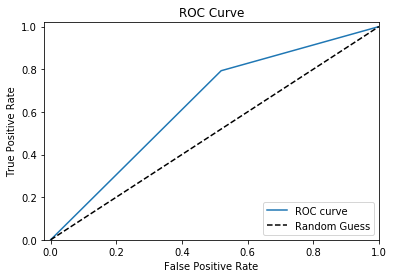

In [7]:
# visualize ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc='lower right')

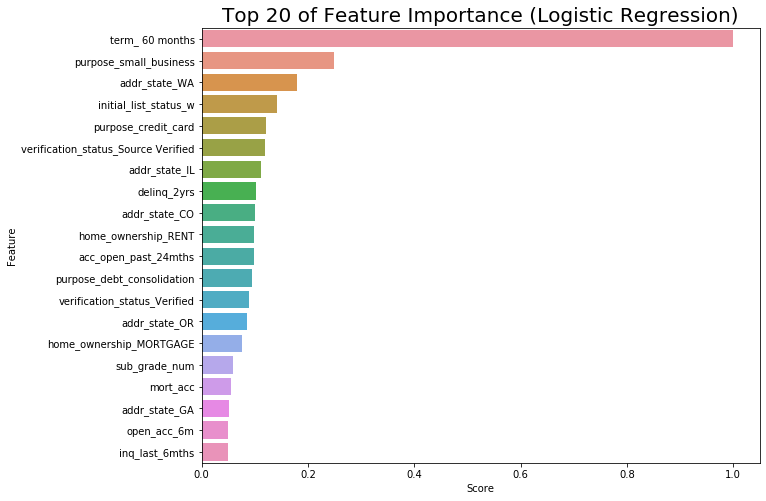

In [8]:
# visualize feature importance
feature_importance = abs(logit_grid.best_estimator_.coef_[0])
feature_importance = feature_importance / feature_importance.max()

plt.figure(figsize=(10, 8))
importances = pd.DataFrame(data={'feature':loans.columns, 'score':feature_importance})
importances = importances.sort_values(by='score', ascending=False)
importances = importances[0:20]

sns.barplot(y=importances['feature'], x=importances['score']).set_title('Top 20 of Feature Importance (Logistic Regression)', fontsize=20)
plt.xlabel("Score")
plt.ylabel("Feature")

plt.show()

### 2. Support Vector Classification

In [14]:
svc_mdl = LinearSVC()

param = {}

svc_grid = GridSearchCV(svc_mdl, param, cv=5, verbose=0)

best_mdl = svc_grid.fit(X_train, Y_train)

# best hyperparameter
print('best hyperparameter')
print(best_mdl.best_estimator_.get_params())
print()

# best cross-validation score
print('best cross-validation score: ' + str(best_mdl.score(X_train, Y_train)))
print()

Y_pred = svc_grid.predict(X_test)

rmse = sqrt(mean_squared_error(Y_test, Y_pred))

print('Root Mean Square Error: ' + str(rmse))
print()

print('Accuracy: ' + str(np.mean(Y_test == Y_pred)))
print()

print(confusion_matrix(Y_test, Y_pred))

best hyperparameter
{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}

best cross-validation score: 0.59760625

Root Mean Square Error: 0.6379851095441021

Accuracy: 0.592975

[[ 7588 10841]
 [ 5440 16131]]


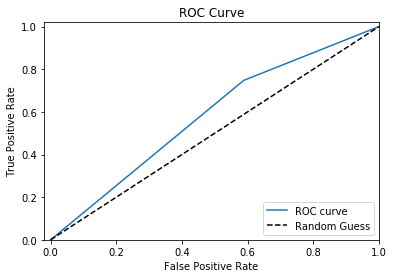

In [19]:
# visualize ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc='lower right')

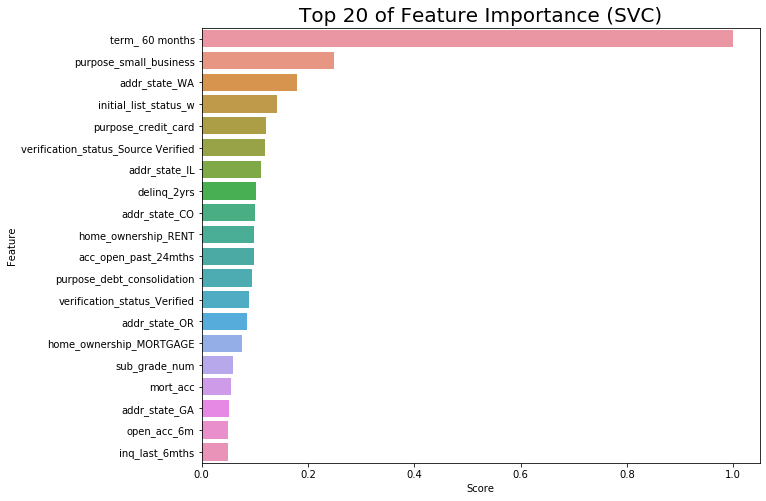

In [18]:
# visualize feature importance
feature_importance = abs(logit_grid.best_estimator_.coef_[0])
feature_importance = feature_importance / feature_importance.max()

plt.figure(figsize=(10, 8))
importances = pd.DataFrame(data={'feature':loans.columns, 'score':feature_importance})
importances = importances.sort_values(by='score', ascending=False)
importances = importances[0:20]

sns.barplot(y=importances['feature'], x=importances['score']).set_title('Top 20 of Feature Importance (SVC)', fontsize=20)
plt.xlabel("Score")
plt.ylabel("Feature")

plt.show()

### 3. XGBoost

In [9]:
xgb_mdl = xgb.XGBClassifier(eval_metric='error')

param = dict(learning_rate=[0.01, 0.1], max_depth=[6, 9, 12])

xgb_grid = GridSearchCV(xgb_mdl, param, n_jobs=10, cv=5, verbose=0)

best_mdl = xgb_grid.fit(X_train, Y_train)

# best hyperparameter
print('best hyperparameter')
print(best_mdl.best_estimator_.get_params())
print()

# best cross-validation score
print('best cross-validation score: ' + str(best_mdl.score(X_train, Y_train)))
print()

Y_pred = xgb_grid.predict(X_test)

rmse = sqrt(mean_squared_error(Y_test, Y_pred))

print('Root Mean Square Error: ' + str(rmse))
print()

print('Accuracy: ' + str(np.mean(Y_test == Y_pred)))
print()

print(confusion_matrix(Y_test, Y_pred))

best hyperparameter
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'eval_metric': 'error'}

best cross-validation score: 0.7772375

Root Mean Square Error: 0.5796981973406508

Accuracy: 0.66395

[[11267  7162]
 [ 6280 15291]]


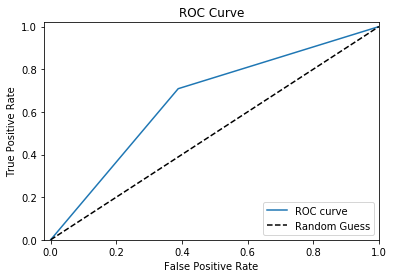

In [11]:
# visualize ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc='lower right')

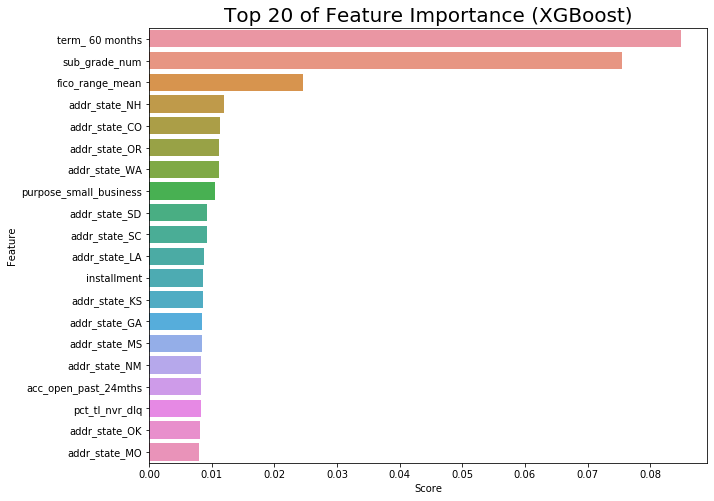

In [12]:
# visualize feature importance
plt.figure(figsize=(10, 8))
importances = pd.DataFrame(data={'feature':loans.columns, 'score':best_mdl.best_estimator_.feature_importances_})
importances = importances.sort_values(by='score', ascending=False)
importances = importances[0:20]

sns.barplot(y=importances['feature'], x=importances['score']).set_title('Top 20 of Feature Importance (XGBoost)', fontsize=20)
plt.xlabel("Score")
plt.ylabel("Feature")

plt.show()

### 4. Random Forest

In [20]:
rf_mdl = RandomForestClassifier()
param = { 
    'n_estimators': [100],
    'criterion' :['gini', 'entropy']
}

rf_grid = GridSearchCV(rf_mdl, param, cv= 5, verbose=0)

best_mdl = rf_grid.fit(X_train, Y_train)

# best hyperparameter
print('best hyperparameter')
print(best_mdl.best_estimator_.get_params())
print()

# best cross-validation score
print('best cross-validation score: ' + str(best_mdl.score(X_train, Y_train)))
print()

Y_pred = rf_grid.predict(X_test)

rmse = sqrt(mean_squared_error(Y_test, Y_pred))

print('Root Mean Square Error: ' + str(rmse))
print()

print('Accuracy: ' + str(np.mean(Y_test == Y_pred)))
print()

print(confusion_matrix(Y_test, Y_pred))

best hyperparameter
{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

best cross-validation score: 1.0

Root Mean Square Error: 0.5845938761225609

Accuracy: 0.65825

[[11062  7367]
 [ 6303 15268]]


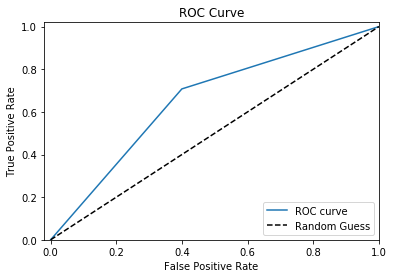

In [21]:
# visualize ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc='lower right')

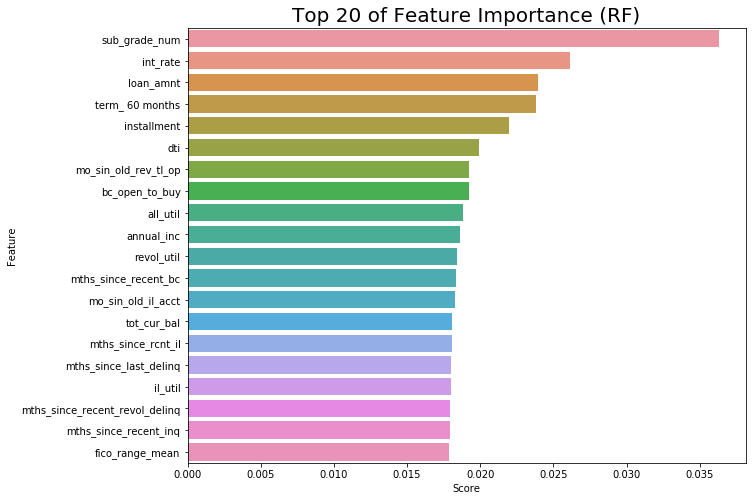

In [22]:
# visualize feature importance
plt.figure(figsize=(10, 8))
importances = pd.DataFrame(data={'feature':loans.columns, 'score':best_mdl.best_estimator_.feature_importances_})
importances = importances.sort_values(by='score', ascending=False)
importances = importances[0:20]

sns.barplot(y=importances['feature'], x=importances['score']).set_title('Top 20 of Feature Importance (RF)', fontsize=20)
plt.xlabel("Score")
plt.ylabel("Feature")

plt.show()

### 5. Tensorflow

In [23]:
import tensorflow as tf

In [24]:
tf.reset_default_graph()

dimension = X_train.shape[1]

X = tf.placeholder(dtype=tf.float32, shape=[None, dimension])
Y = tf.placeholder(dtype=tf.float32, shape=[None, 1])
W = tf.Variable(tf.random_normal(shape=[dimension, 1]), dtype=tf.float32)
b = tf.Variable(tf.random_normal(shape=[1, 1]), dtype=tf.float32)

mod = tf.matmul(X, W) + b

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=mod, labels=Y))
opt = tf.train.GradientDescentOptimizer(learning_rate=0.5)
goal = opt.minimize(loss)

prediction = tf.round(tf.sigmoid(mod))
correct = tf.cast(tf.equal(prediction, Y), dtype=tf.float32)
accuracy = tf.reduce_mean(correct)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
loss_trace = []
train_acc = []
test_acc = []

batch_size = 500
iter_num = 10000

init = tf.global_variables_initializer()

Y_train = Y_train.reset_index(drop=True)

with tf.Session() as sess:
    init.run()
    for epoch in range(iter_num):
        batch_index = np.random.choice(len(X_train), size=batch_size)

        batch_train_X = X_train[batch_index]
        batch_train_y = np.matrix(Y_train[batch_index]).T
        
        sess.run(goal, feed_dict={X: batch_train_X, Y: batch_train_y})
        temp_loss = sess.run(loss, feed_dict={X: batch_train_X, Y: batch_train_y})

        temp_train_acc = sess.run(accuracy, feed_dict={X: X_train, Y: np.matrix(Y_train).T})
        temp_test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: np.matrix(Y_test).T})

        loss_trace.append(temp_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)

        if (epoch + 1) % 500 == 0:
            print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss, temp_train_acc, temp_test_acc))

epoch:  500 loss: 0.674407 train_acc: 0.579869 test_acc: 0.577975
epoch: 1000 loss: 0.679408 train_acc: 0.586831 test_acc: 0.583700
epoch: 1500 loss: 0.666930 train_acc: 0.588975 test_acc: 0.586675
epoch: 2000 loss: 0.687714 train_acc: 0.590144 test_acc: 0.587425
epoch: 2500 loss: 0.685745 train_acc: 0.590650 test_acc: 0.586625
epoch: 3000 loss: 0.671560 train_acc: 0.591606 test_acc: 0.588250
epoch: 3500 loss: 0.662872 train_acc: 0.592606 test_acc: 0.588575
epoch: 4000 loss: 0.672522 train_acc: 0.592687 test_acc: 0.588375
epoch: 4500 loss: 0.665512 train_acc: 0.593100 test_acc: 0.589375
epoch: 5000 loss: 0.669576 train_acc: 0.592906 test_acc: 0.588400
epoch: 5500 loss: 0.669223 train_acc: 0.593550 test_acc: 0.588900
epoch: 6000 loss: 0.659677 train_acc: 0.593912 test_acc: 0.589400
epoch: 6500 loss: 0.679156 train_acc: 0.593950 test_acc: 0.589625
epoch: 7000 loss: 0.669672 train_acc: 0.594756 test_acc: 0.590100
epoch: 7500 loss: 0.662406 train_acc: 0.594125 test_acc: 0.589175
epoch: 800